# Titanic-Modellierung: Klassifikation, Interpretierbarkeit und Fairness

Dieses Notebook führt ein vollständiges End-to-End-Beispiel durch:
1. Daten laden  
2. Preprocessing-Pipeline  
3. Modelle (lineare Modelle, Bäume, Ensembles, Boosting)  
4. Interpretierbarkeit (Feature Importance, SHAP)  
5. Fairness (Gruppenmetriken)

## Kapitel 1: Daten laden und erste Vorbereitung

Wir verwenden den **Titanic-Datensatz** aus `seaborn`.

Zielvariable: `survived`  
Mögliche Prädiktoren (Auswahl): `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embarked`, `who`, `alone` usw.

Hinweis:
- Die Spalte `alive` ist eine textuelle Version von `survived` und wird als Feature weggelassen, um Datenleckage zu vermeiden.
- Wir unterscheiden:
  - numerische Features
  - kategoriale Features

Dies bildet die Grundlage für die Preprocessing-Pipeline n Kapitel 2.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

# Titanic-Datensatz aus seaborn laden
df = sns.load_dataset("titanic")

# Grundlegender Blick auf die Daten
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Zielvariable und Features definieren

Zielvariable: `survived` (0 = nicht überlebt, 1 = überlebt)

Wir entfernen Spalten, die:
- direkt die Zielvariable widerspiegeln (`alive`),
- oder rein beschreibenden Charakter haben und redundant sind (z. B. `class` als textuelle Version von `pclass`), falls gewünscht.

Die Auswahl der Features ist immer auch eine Modellierungsentscheidung.  
Hier wählen wir eine typische Untermenge.

In [2]:
# Zielvariable definieren
target_col = "survived"

# Beispielhafte Feature-Auswahl:
drop_cols = [
    target_col,
    "alive",    # textuelle Version der Zielvariable
    "class"     # textuelle Version von pclass, optional
]

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].copy()
y = df[target_col].copy()

X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,deck,embark_town,alone
0,3,male,22.0,1,0,7.2500,S,man,True,NaN,Southampton,False
1,1,female,38.0,1,0,71.2833,C,woman,False,C,Cherbourg,False
2,3,female,26.0,0,0,7.9250,S,woman,False,NaN,Southampton,True
3,1,female,35.0,1,0,53.1000,S,woman,False,C,Southampton,False
4,3,male,35.0,0,0,8.0500,S,man,True,NaN,Southampton,True


### Datentypen und Train-Test-Split

Wir unterscheiden:
- numerische Variablen: z. B. `age`, `fare`, `sibsp`, `parch`
- kategoriale Variablen: z. B. `sex`, `embarked`, `who`, `deck`, `alone`

Anschließend teilen wir die Daten in:
- Trainingsdaten: für das Fitten der Modelle
- Testdaten: für die unabhängige Evaluation der Modelle

In [3]:
# Numerische und kategoriale Features bestimmen
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

print("Numerische Features:", numeric_features)
print("Kategoriale Features:", categorical_features)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

Numerische Features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Kategoriale Features: ['sex', 'embarked', 'who', 'adult_male', 'deck', 'embark_town', 'alone']


((712, 12), (179, 12))

### Überprüfung der Datenqualität

Bevor wir Modelle trainieren, prüfen wir:

- Anzahl der Beobachtungen und Features
- Fehlende Werte
- Verteilung der Zielvariable

Dies hilft, spätere Probleme (z. B. wegen vieler NaN oder stark unausgeglichener Klassen) früh zu erkennen.

In [4]:
print("Gesamt-Shape:", df.shape)
print()

print("Fehlende Werte pro Spalte:")
display(df.isna().sum())

print("Zielverteilung (absolut):")
display(y.value_counts())

print("Zielverteilung (relativ):")
display(y.value_counts(normalize=True))

Gesamt-Shape: (891, 15)

Fehlende Werte pro Spalte:


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Zielverteilung (absolut):


survived
0    549
1    342
Name: count, dtype: int64

Zielverteilung (relativ):


survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

### Fazit Kapitel 1

- Der Titanic-Datensatz aus `seaborn` ist geladen.
- Zielvariable `survived` ist definiert.
- Eine Feature-Auswahl ist getroffen (ohne Datenleckage über `alive`).
- Die Daten sind in Trainings- und Testdaten aufgeteilt.
- Wir haben einen Überblick über fehlende Werte und die Zielverteilung.

Im nächsten Kapitel bauen wir eine einheitliche **Preprocessing-Pipeline**:
- numerische Variablen: Standardisierung  
- kategoriale Variablen: One-Hot-Encoding  

Die Pipeline ermöglicht es, verschiedene Modelle konsistent und vergleichbar zu trainieren.

## Kapitel 2: Preprocessing-Pipeline

Bevor wir Modelle trainieren, bereiten wir die Daten einheitlich vor.

Wir verwenden eine Pipeline mit:

1. Imputation fehlender Werte  
2. Standardisierung numerischer Variablen  
3. One-Hot-Encoding kategorialer Variablen  
4. Zusammenführung über einen `ColumnTransformer`  

Alle späteren Modelle erhalten damit dieselbe, konsistent vorbereitee Eingabe.


### Imputation numerischer und kategorialer Variablen

Fehlende Werte können viele Modelle stören.  
Wir ersetzen sie daher systematisch:

- numerische Variablen: Median-Imputation  
- kategoriale Variablen: häufigste Kategorie (Modus)

Formal für numerische Werte:

$$
\tilde{x}_j =
\begin{cases}
x_j, & \text{falls nicht fehlend}, \\
\text{Median der Spalte } j, & \text{falls fehlend}.
\end{cases}
$$end{cases}
$$



### Standardisierung numerischer Variablen

Für numerische Variablen verwenden wir Standardisierung:

$$
z = \frac{x - \mu}{\sigma}.
$$

Dies ist besonders relevant für:

- lineare Modelle mit Regularisierung (z. B. logistische Regression)  
- Modelle, die von der Skala der Features abhängen


### One-Hot-Encoding kategorialer Variablen

Kategoriale Variablen mit $k$ Ausprägungen werden in $k$ Binärvariablen überführt.

Beispiel:  
`sex` mit Kategorien {male, female} wird zu

- `sex_male`  
- `sex_female`.

Formal: Jede Kategorie $c_j$ wird auf einen Einheitsvektor

$$
e_j = (0, \dots, 0, 1, 0, \dots, 0)
$$

abgebildet (1 an Position $j$).

### ColumnTransformer

Wir kombinieren alle Schritte in einem `ColumnTransformer`:

$$
T(x) = \left(
  T_{\text{num}}(x_{\text{num}}),
  T_{\text{cat}}(x_{\text{cat}})
\right),
$$

wobei

- $T_{\text{num}}$: Imputation + Standardisierung  
- $T_{\text{cat}}$: Imputation + One-Hot-Encoding

Die Ausgabe von $T$ ist eine numerische Feature-Matrix, die allen Modellen zur Verfügung steht.


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Wir verwenden die numeric_features und categorical_features aus Kapitel 1
print("Numerische Features:", numeric_features)
print("Kategoriale Features:", categorical_features)

# Pipeline für numerische Spalten
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Pipeline für kategoriale Spalten
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Gemeinsamer ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Test: auf Trainingsdaten fitten und transformieren
X_train_trans = preprocess.fit_transform(X_train)

X_train_trans.shape

Numerische Features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Kategoriale Features: ['sex', 'embarked', 'who', 'adult_male', 'deck', 'embark_town', 'alone']


(712, 27)

### Feature-Namen nach der Transformation

Nach der Transformation existieren:

- standardisierte numerische Features (mit Präfix `num__`)  
- One-Hot-kodierte kategoriale Features (mit Präfix `cat__`)

Wir lesen diese Namen direkt aus dem gefitteten `ColumnTransformer` aus:

$$
\mathcal{F} = \{f_1, \dots, f_p\},
$$

wobei jedes $f_j$ ein transformiertes Feature (z. B. `cat__who_man`) darstellt.


In [6]:
# Wir verwenden direkt den gefitteten ColumnTransformer "preprocess".

feature_names_all = preprocess.get_feature_names_out()

len(feature_names_all), feature_names_all[:20]


(27,
 array(['num__pclass', 'num__age', 'num__sibsp', 'num__parch', 'num__fare',
        'cat__sex_female', 'cat__sex_male', 'cat__embarked_C',
        'cat__embarked_Q', 'cat__embarked_S', 'cat__who_child',
        'cat__who_man', 'cat__who_woman', 'cat__adult_male_False',
        'cat__adult_male_True', 'cat__deck_A', 'cat__deck_B',
        'cat__deck_C', 'cat__deck_D', 'cat__deck_E'], dtype=object))

### Fazit Kapitel 2

Wir haben nun:

- eine robuste Preprocessing-Pipeline mit Imputation, Standardisierung und One-Hot-Encoding,  
- die Pipeline erfolgreich auf die Trainingsdaten gefittet,  
- die vollständige Liste der transformierten Feature-Namen verfügbar.

Damit sind wir bereit für Kapitel 3:

- Aufbau von Klassifikationsmodellen (logistische Regression, Entscheidungsbaum, Random Forest, Boosting)  
- stets mit derselben Preprocessing-Pipeline `preprocess`.


## Kapitel 3: Einfache Basismodelle

In diesem Kapitel trainieren wir drei grundlegende Klassifikationsmodelle:

1. Logistische Regression  
2. Entscheidungsbaum  
3. Random Forest  

Alle Modelle verwenden dieselbe Preprocessing-Pipeline aus Kapitel 2.
Damit ist ein fairer Vergleich möglich.


### Einheitliche Evaluation der Modelle

Für alle Modelle verwenden wir dieselbe Evaluationsfunktion.

Wir berechnen:

- Accuracy:
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
- Precision:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
- Recall (Sensitivity, True Positive Rate, TPR):
  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$
- Specificity (True Negative Rate, TNR):
  $$
  \text{TNR} = \frac{TN}{TN + FP}
  $$
- False Positive Rate (FPR):
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$
- F1-Score:
  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
- ROC-AUC (Fläche unter der ROC-Kurve)
- Positive Rate:
  $$
  \text{PosRate} = \frac{\#\{\hat{y}_i = 1\}}{n}
  $$

Die Positivrate, TPR und FPR sind später für Fairnessvergleiche wichtig (Vergleich zwischen Gruppen).
Wir speichern zusätzlich:

- das trainierte Modell
- die Vorhersagen `y_pred`
- die Wahrscheinlichkeiten `y_proba`

in einem gemeinsamen Dictionary `model_results`.


In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

model_results = {}  # zentrales Dict, falls noch nicht definiert

def evaluate_model(name, model, X_train, y_train, X_test, y_test, plot_cm=True):
    """
    Trainiert das Modell, berechnet Metriken und speichert alles in model_results[name].
    """
    # Modell fitten
    model.fit(X_train, y_train)
    
    # Vorhersagen
    y_pred = model.predict(X_test)
    
    # Wahrscheinlichkeiten (falls verfügbar)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = float("nan")
    
    # Konfusionsmatrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Basis-Metriken
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)   # = TPR
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Weitere Metriken für spätere Fairness-Analysen
    tpr = rec
    tnr = tn / (tn + fp) if (tn + fp) > 0 else float("nan")
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float("nan")
    fnr = fn / (fn + tp) if (fn + tp) > 0 else float("nan")
    pos_rate = (y_pred == 1).mean()
    
    metrics = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall_TPR": tpr,
        "Specificity_TNR": tnr,
        "FPR": fpr,
        "FNR": fnr,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "PositiveRate": pos_rate,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }
    
    print(f"=== {name} ===")
    for k, v in metrics.items():
        if k in ["TP", "TN", "FP", "FN"]:
            print(f"{k:>15}: {v}")
        else:
            print(f"{k:>15}: {v:.3f}")
    print()
    
    if plot_cm:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=["nicht überlebt (0)", "überlebt (1)"],
        )
        disp.plot(values_format="d")
        plt.title(f"Confusion Matrix – {name}")
        plt.tight_layout()
        plt.show()
    
    # Ergebnisse zentral speichern
    model_results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "metrics": metrics,
    }
    
    return metrics


### Logistische Regression

Die logistische Regression modelliert die Überlebenswahrscheinlichkeit als

$$
P(Y = 1 \mid x) = \sigma(\beta_0 + x^\top \beta),
$$

wobei

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

die logistische Funktion ist.

Eigenschaften:
- lineares Entscheidungsmodell  
- gut interpretierbare Koeffizienten  
- Standardmodell für binäre Klassifikation  
- benötigt skalierte Eingaben (durch unsere Pipeline gegeben)


=== Logistische Regression ===
       Accuracy: 0.827
      Precision: 0.788
     Recall_TPR: 0.754
Specificity_TNR: 0.873
            FPR: 0.127
            FNR: 0.246
             F1: 0.770
        ROC-AUC: 0.863
   PositiveRate: 0.369
             TP: 52
             TN: 96
             FP: 14
             FN: 17



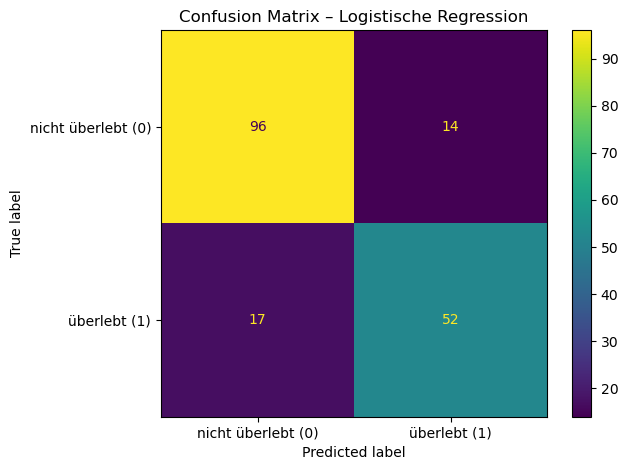

In [8]:
from sklearn.linear_model import LogisticRegression

logreg_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

logreg_metrics = evaluate_model(
    name="Logistische Regression",
    model=logreg_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)

### Entscheidungsbaum

Ein Entscheidungsbaum partitioniert den Feature-Raum rekursiv:

- An jedem Knoten wird ein Feature ausgewählt  
- Das Feature wird bei einem Schwellenwert geteilt  
- Ziel ist die Minimierung der Impurity

Typische Impurity-Maße:
- **Gini-Impurity**  
  $$
  G = \sum_k p_k (1 - p_k)
  $$
- **Entropie**  
  $$
  H = -\sum_k p_k \log p_k
  $$

Vorteile:
- gut interpretierbar  
- kann nichtlineare Beziehungen abbilden

Nachteile:
- anfällig für Overfitting  


=== Entscheidungsbaum ===
       Accuracy: 0.810
      Precision: 0.778
     Recall_TPR: 0.710
Specificity_TNR: 0.873
            FPR: 0.127
            FNR: 0.290
             F1: 0.742
        ROC-AUC: 0.852
   PositiveRate: 0.352
             TP: 49
             TN: 96
             FP: 14
             FN: 20



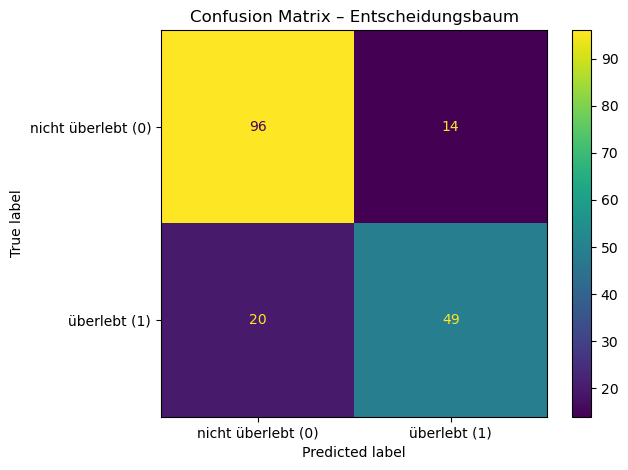

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", DecisionTreeClassifier(
            max_depth=4,
            random_state=42
        ))
    ]
)

dt_metrics = evaluate_model(
    name="Entscheidungsbaum",
    model=dt_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)

### Random Forest

Ein Random Forest kombiniert viele Entscheidungsbäume.

Algorithmus:
1. Bootstrap-Stichproben aus dem Trainingsset  
2. Für jeden Baum: zufällige Auswahl eines Subsets von Features  
3. Mittelung der Vorhersagen über alle Bäume

Formell:

$$
\hat{f}(x) = \frac{1}{B} \sum_{b=1}^B f_b(x),
$$

wobei $f_b$ der $b$-te Entscheidungsbaum ist.

Eigenschaften:
- robust  
- gute Standard-Performance  
- weniger Overfitting als einzelne Bäume  
- liefert Feature Importances


=== Random Forest ===
       Accuracy: 0.816
      Precision: 0.810
     Recall_TPR: 0.681
Specificity_TNR: 0.900
            FPR: 0.100
            FNR: 0.319
             F1: 0.740
        ROC-AUC: 0.836
   PositiveRate: 0.324
             TP: 47
             TN: 99
             FP: 11
             FN: 22



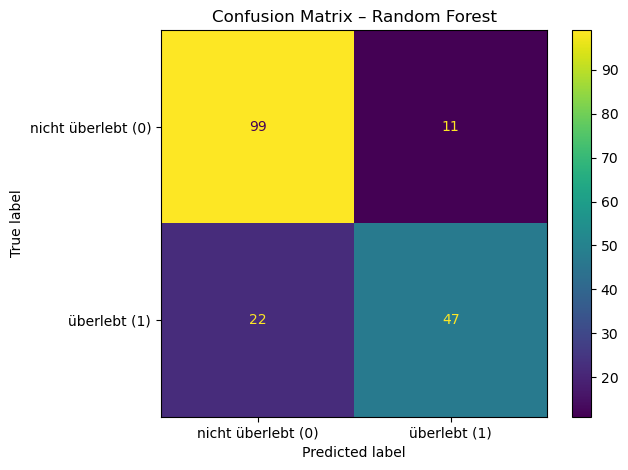

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=42
        ))
    ]
)

rf_metrics = evaluate_model(
    name="Random Forest",
    model=rf_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)


### Vergleich der Basismodelle

Wir fassen die Metriken aller drei Modelle in einer Tabelle zusammen.


In [11]:
# DataFrame aus dem zentralen model_results-Dict erstellen
metrics_df = pd.DataFrame({
    name: res["metrics"] for name, res in model_results.items()
}).T

metrics_df

,Accuracy,Precision,Recall_TPR,Specificity_TNR,FPR,FNR,F1,ROC-AUC,PositiveRate,TP,TN,FP,FN
Logistische Regression,0.826816,0.787879,0.753623,0.872727,0.127273,0.246377,0.770370,0.863373,0.368715,52.0,96.0,14.0,17.0
Entscheidungsbaum,0.810056,0.777778,0.710145,0.872727,0.127273,0.289855,0.742424,0.852437,0.351955,49.0,96.0,14.0,20.0
Random Forest,0.815642,0.810345,0.681159,0.900000,0.100000,0.318841,0.740157,0.835639,0.324022,47.0,99.0,11.0,22.0


### Fazit Kapitel 3

Wir haben drei grundlegende Klassifikationsmodelle trainiert und verglichen:

- Logistische Regression: gutes lineares Basismodell  
- Entscheidungsbaum: interpretierbar, aber riskant bzgl. Overfitting  
- Random Forest: robuste Performance, gute Standardwahl  

Diese Modelle bilden die Grundlage für das nächste Kapitel

## Kapitel 4: Boosting-Methoden

In diesem Kapitel betrachten wir drei Boosting-Ansätze:

1. AdaBoost  
2. Gradient Boosting (scikit-learn)  
3. XGBoost (externe Bibliothek)

Boosting kombiniert viele schwache Modelle (meist Entscheidungsbäume) zu einem starken Modell.

Ziel:
- aufeinanderfolgende Modelle korrigieren die Fehler der vorherigen
- starke Performance, besonders bei tabellarischen Daten


### 4.1 AdaBoost

AdaBoost („Adaptive Boosting“) passt die Gewichte der Trainingsbeispiele iterativ an.

Idee:

1. Starte mit gleichen Gewichten für alle Datenpunkte  
2. Trainiere einen schwachen Klassifikator (z. B. DecisionStump)  
3. Erhöhe die Gewichte der falsch klassifizierten Punkte  
4. Trainiere den nächsten Klassifikator, der sich auf schwierige Punkte konzentriert  
5. Finales Modell ist eine gewichtete Summe aller Klassifikatoren:

$$
F(x) = \sum_{m=1}^M \alpha_m h_m(x),
$$

wobei  
- $ h_m(x) $ schwache Modelle sind  
- $ \alpha_m $ deren Gewichte (abhängig von der Fehlerrate)

Eigenschaften:
- schnell  
- robust gegen Overfitting (bei geeigneter Lernrate)  
- sehr gut für tabellarische Klassifikationsaufgaben  


=== AdaBoost ===
       Accuracy: 0.816
      Precision: 0.773
     Recall_TPR: 0.739
Specificity_TNR: 0.864
            FPR: 0.136
            FNR: 0.261
             F1: 0.756
        ROC-AUC: 0.858
   PositiveRate: 0.369
             TP: 51
             TN: 95
             FP: 15
             FN: 18



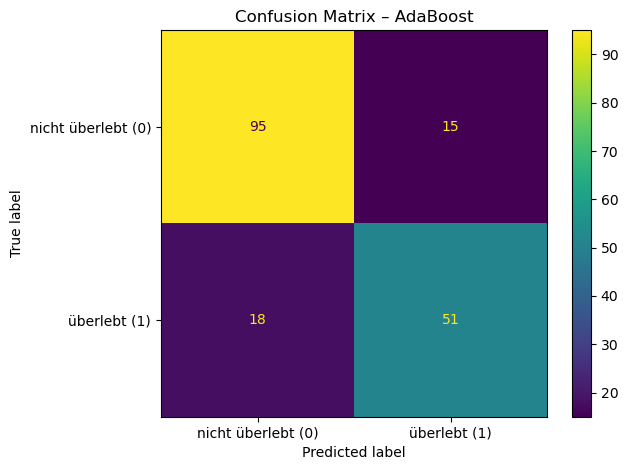

{'Accuracy': 0.8156424581005587,
 'Precision': 0.7727272727272727,
 'Recall_TPR': 0.7391304347826086,
 'Specificity_TNR': np.float64(0.8636363636363636),
 'FPR': np.float64(0.13636363636363635),
 'FNR': np.float64(0.2608695652173913),
 'F1': 0.7555555555555555,
 'ROC-AUC': 0.8575757575757577,
 'PositiveRate': np.float64(0.3687150837988827),
 'TP': np.int64(51),
 'TN': np.int64(95),
 'FP': np.int64(15),
 'FN': np.int64(18)}

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=200,
            learning_rate=0.5,
            random_state=42
        ))
    ]
)

ada_metrics = evaluate_model(
    name="AdaBoost",
    model=ada_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)

ada_metrics

### 4.2 Gradient Boosting

Gradient Boosting optimiert iterativ eine differentiierbare Loss-Funktion  
(z. B. Log-Loss für Klassifikation).

Algorithmus:

1. Starte mit einem Basiswert  
2. Berechne die **Pseudo-Residuen** (Gradienten der Loss-Funktion)  
3. Fit eines Regressionsbaums auf die Residuen  
4. Update:

$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x),
$$

mit Lernrate \( \nu \in (0, 1] \).

Eigenschaften:
- sehr flexibel  
- gut interpretierbar  
- kann Interaktionen zwischen Features gut abbilden  
- empfindlich gegenüber Ausreißern, aber gut durch Regularisierung steuerbar


=== Gradient Boosting ===
       Accuracy: 0.816
      Precision: 0.821
     Recall_TPR: 0.667
Specificity_TNR: 0.909
            FPR: 0.091
            FNR: 0.333
             F1: 0.736
        ROC-AUC: 0.851
   PositiveRate: 0.313
             TP: 46
             TN: 100
             FP: 10
             FN: 23



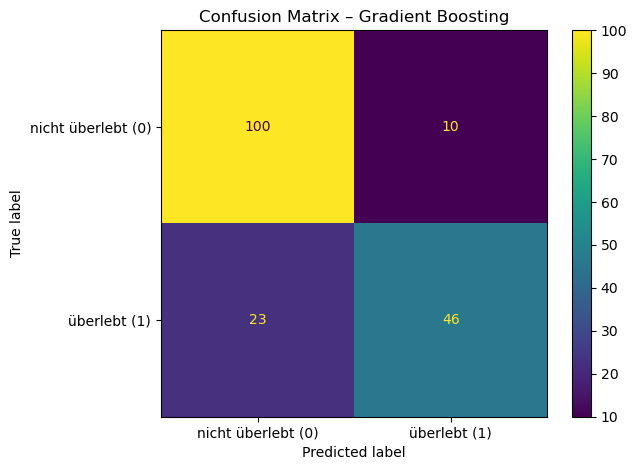

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb_metrics = evaluate_model(
    name="Gradient Boosting",
    model=gb_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)

gb_metrics;

### 4.3 XGBoost

XGBoost („Extreme Gradient Boosting“) ist eine optimierte Variante von Gradient Boosting:

Hauptideen:

- zweite Ableitung (Newton-Schritt) wird für Updates verwendet  
- Regularisierung der Bäume
- sparsity-aware (geht gut mit fehlenden Werten um)  
- parallele Baumkonstruktion  
- Features werden nach Gain sortiert (Split-Finding sehr effizient)

Optimierungsziel:

$$
\mathcal{L} = \sum_i l(y_i, \hat{y}_i)
        + \sum_{m} \Omega(f_m),
$$

mit Regularisierungsterm

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_j w_j^2.
$$

Eigenschaften:
- State-of-the-art für tabellarische Daten  
- meist bessere Performance als sklearn-GradientBoosting  
- viele Hyperparameter, aber gute Defaults  


=== XGBoost ===
       Accuracy: 0.832
      Precision: 0.831
     Recall_TPR: 0.710
Specificity_TNR: 0.909
            FPR: 0.091
            FNR: 0.290
             F1: 0.766
        ROC-AUC: 0.844
   PositiveRate: 0.330
             TP: 49
             TN: 100
             FP: 10
             FN: 20



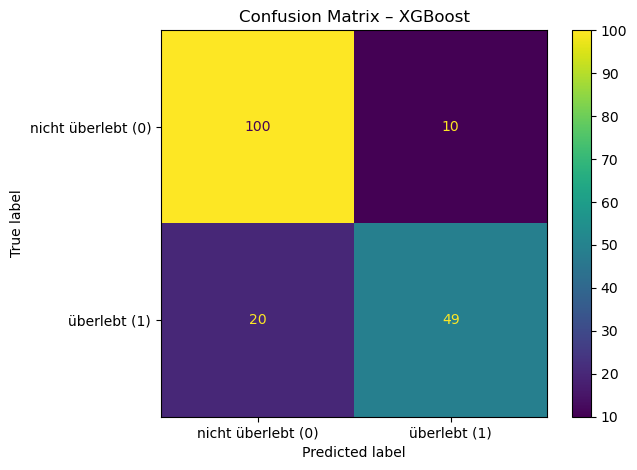

{'Accuracy': 0.8324022346368715,
 'Precision': 0.8305084745762712,
 'Recall_TPR': 0.7101449275362319,
 'Specificity_TNR': np.float64(0.9090909090909091),
 'FPR': np.float64(0.09090909090909091),
 'FNR': np.float64(0.2898550724637681),
 'F1': 0.765625,
 'ROC-AUC': 0.8440711462450593,
 'PositiveRate': np.float64(0.329608938547486),
 'TP': np.int64(49),
 'TN': np.int64(100),
 'FP': np.int64(10),
 'FN': np.int64(20)}

In [14]:
from xgboost import XGBClassifier

xgb_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb_metrics = evaluate_model(
    name="XGBoost",
    model=xgb_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_cm=True
)

xgb_metrics


### 4.4 Vergleich der Boosting-Modelle

Wir vergleichen die drei Boosting-Verfahren anhand aller zentralen Metriken.


In [15]:
boosting_df = pd.DataFrame({
    "AdaBoost": ada_metrics,
    "Gradient Boosting": gb_metrics,
    "XGBoost": xgb_metrics
}).T

boosting_df

,Accuracy,Precision,Recall_TPR,Specificity_TNR,FPR,FNR,F1,ROC-AUC,PositiveRate,TP,TN,FP,FN
AdaBoost,0.815642,0.772727,0.739130,0.863636,0.136364,0.260870,0.755556,0.857576,0.368715,51.0,95.0,15.0,18.0
Gradient Boosting,0.815642,0.821429,0.666667,0.909091,0.090909,0.333333,0.736000,0.851252,0.312849,46.0,100.0,10.0,23.0
XGBoost,0.832402,0.830508,0.710145,0.909091,0.090909,0.289855,0.765625,0.844071,0.329609,49.0,100.0,10.0,20.0


### Fazit Kapitel 4



## Kapitel 5: Interpretierbarkeit

Interpretierbarkeit beantwortet die Frage:

**Warum trifft ein Modell eine bestimmte Vorhersage?**

Wir unterscheiden:

1. **Globale Interpretierbarkeit**  
   – Welche Features sind insgesamt wichtig?  
   – Wie wirken Features durchschnittlich?

2. **Lokale Interpretierbarkeit**  
   – Warum wurde bei *dieser einen Person* genau diese Entscheidung getroffen?

Wir betrachten:
- Feature Importance (modellbasiert & permutation)
- Partial Dependence Plots (PDP)
- Individual Conditional Expectation (ICE)
- SHAP (global & lokal)
- LIME (lokal)



In [16]:
models_for_interpret = {
    "LogReg": logreg_clf,
    "DecisionTree": dt_clf,
    "RandomForest": rf_clf,
    "GradientBoosting": gb_clf,
    "XGBoost": xgb_clf
}

# Modelle trainieren (falls noch nicht geschehen)
for name, mdl in models_for_interpret.items():
    mdl.fit(X_train, y_train)

### 5.1 Modellabhängige Feature Importance

Je nach Modell bestehen unterschiedliche Interpretationsansätze:

**Logistische Regression:**  
Koeffizienten zeigen Richtung & Stärke des Einflusses im linearen Logit-Modell.

**Baumbasierte Modelle:**  
Impurity-basiertes Importance-Maß (Gini / Entropy / Gain).

Wichtig:
Die Importances verschiedener Bäume sind **nicht vergleichbar** ohne Normalisierung.


Beispiel: Baumbasierte Modelle bieten eine interne Metrik:

**Gini Importance / Mean Decrease in Impurity**

Für jedes Feature:

$$
\text{Importance}(j) = \sum_{t \in \text{Splits mit Feature } j}
p(t) \cdot \Delta \text{Impurity}(t)
$$

Eigenschaften:
- schnell
- baum-spezifisch
- kann Features mit vielen Kategorien bevorzugen

Wir zeigen die Importance für das Modell `best_model`, sofern es `feature_importances_` besitzt.

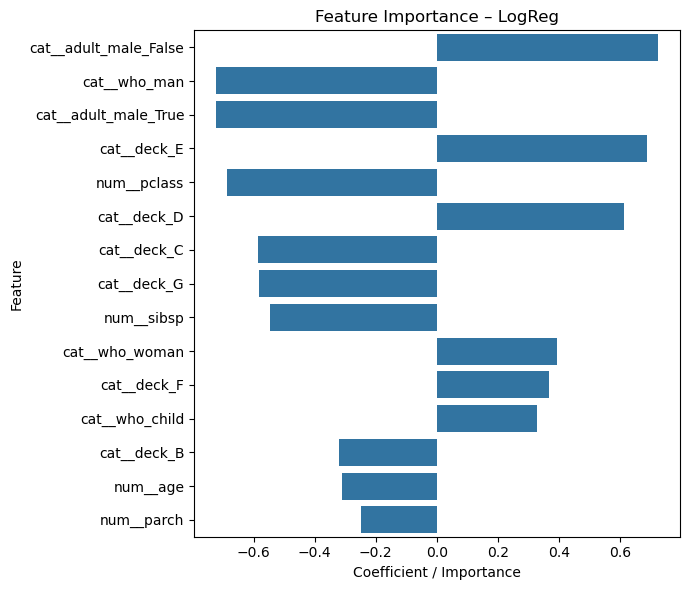

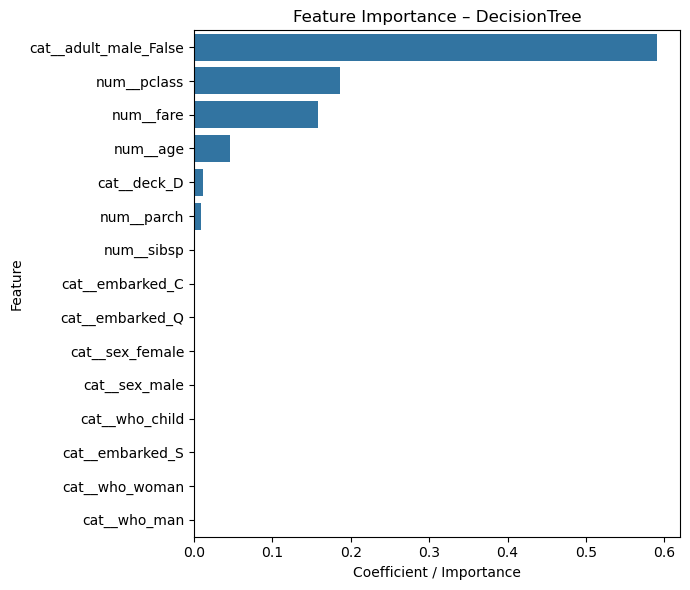

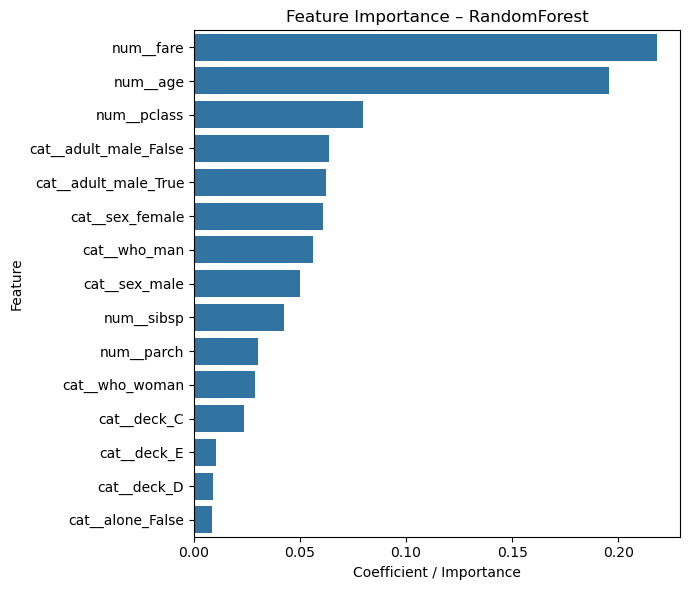

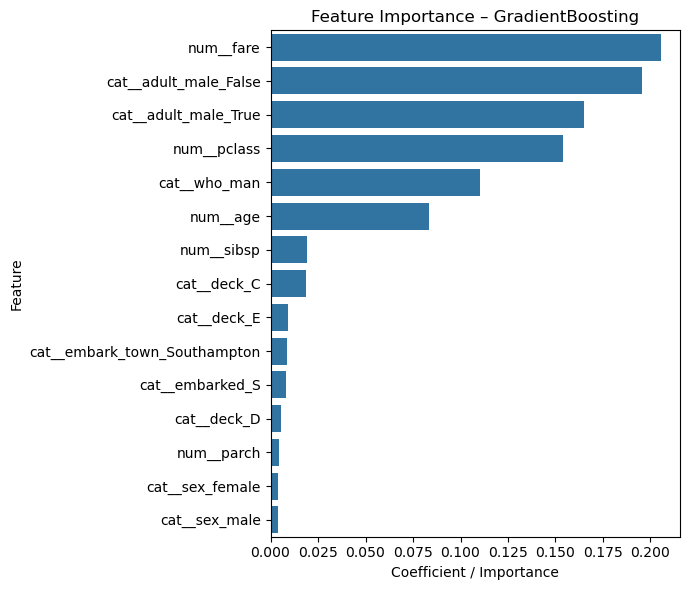

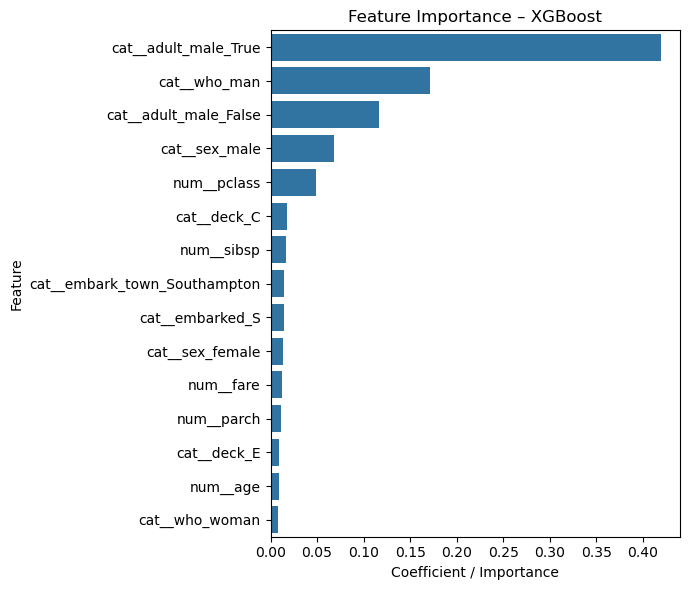

In [17]:
for name, model in models_for_interpret.items():
    preprocess_fitted = model.named_steps["preprocess"]
    feature_names = preprocess_fitted.get_feature_names_out()
    mdl = model.named_steps["model"]

    # Logistische Regression
    if name == "LogReg":
        coefs = mdl.coef_[0]
        df = pd.DataFrame({"feature": feature_names, "importance": coefs})
        df = df.reindex(df["importance"].abs().sort_values(ascending=False).index)
    else:
        # Baum-Modelle
        if hasattr(mdl, "feature_importances_"):
            df = pd.DataFrame({
                "feature": feature_names,
                "importance": mdl.feature_importances_
            }).sort_values("importance", ascending=False)
        else:
            df = None

    # Einzel-Plot
    plt.figure(figsize=(7, 6))
    if df is not None:
        sns.barplot(
            data=df.head(15),
            y="feature",
            x="importance",
            legend=False  # Sicherheitsmaßnahme für zukünftige Versionen
        )
        plt.title(f"Feature Importance – {name}")
        plt.xlabel("Coefficient / Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{name} hat keine feature_importances_.")



# Warum unterscheiden sich die Feature Importances je nach Modell so stark?

Die Visualisierungen zeigen, dass Logistische Regression, Decision Tree, Random Forest, Gradient Boosting und XGBoost sehr unterschiedliche Feature Importances erzeugen.  
Das ist kein Fehler – es liegt daran, dass jedes Modell einen *anderen mathematischen Mechanismus* besitzt und damit eine *eigene Definition* von „Wichtigkeit“.


## 1. Unterschiedliche mathematische Modelle → unterschiedliche Wichtigkeitsbegriffe

### Logistische Regression
Lineares Modell:

$$\hat y = \sigma(\beta_0 + \sum_{j} \beta_j x_j)$$

- Wichtigkeit = Koeffizientenbetrag \(|\beta_j|\)
- Vorzeichen ist bedeutend (positiv = erhöht Überleben)
- Keine automatischen Interaktionen
- One-Hot-Kategorien konkurrieren miteinander → große Vorzeichenunterschiede

→ Viele Features erscheinen moderat wichtig, Effekte sind glatt und linear.

---

### Entscheidungsbaum
- Baum wählt pro Knoten *ein einziges* Feature für den Split.
- Wichtigkeit = gesamte Gini-Impurity-Reduktion:

$$\Delta I = I_{\text{vorher}} - I_{\text{nachher}}$$

- Features, die früh im Baum gesplittet werden → extrem hohe Importance
- Features, die nie gesplittet werden → Importance = 0

→ Ein einzelnes Feature kann dominieren, andere verschwinden vollständig.

---

### Random Forest
- Mittelung über viele Trees
- Wichtigkeit = mittlere Impurity-Reduktion über alle Bäume
- Zufällige Feature-Auswahl verhindert extreme Dominanz
- Korrelierten Features wird die Wichtigkeit oft aufgeteilt

→ Glatteres Importance-Profil, weniger extreme Ausreißer.

---

### Gradient Boosting
- Mehrere kleine Bäume werden sequentiell auf Residuen trainiert
- Wichtigkeit = Reduktion der Loss-Funktion über alle Bäume hinweg
- Interaktionen werden automatisch gefunden

→ Wenige starke Features dominieren, aber weniger extrem als beim Einzelbaum.

---

### XGBoost
- Gradient Boosting + Regularisierung + 2nd-order-Optimierung
- Wichtigkeit basiert typischerweise auf dem **Gain**
- Sehr empfindlich gegenüber Interaktionen
- Regulierung kann Importances stärker spreizen oder fokussieren

→ Sehr fokussiertes Importance-Profil, oft stärker als bei scikit-Boosting.


## 2. Unterschiedliche Sensitivität gegenüber One-Hot-Encoding

Kategorielle Variablen wie `sex`, `who`, `pclass`, `embarked` werden in jedes Modell unterschiedlich integriert:

- **LogReg:** Kategorien konkurrieren → positive und negative Koeffizienten
- **Trees:** nutzen nur einzelne Kategorien häufig → manche One-Hots dominant
- **RF/GB/XGB:** manche Kategorien werden nie genutzt → Importance = 0

→ Deshalb ist z. B. `cat__adult_male_True` in manchen Modellen extrem wichtig und in anderen völlig unbedeutend.


## 3. Unterschiedliche Fähigkeit zur Modellierung von Interaktionen

- **Logistische Regression:**  
  keine Interaktionen, außer man fügt sie explizit hinzu  
  → glatte, lineare Effekte

- **Trees, RF, GB, XGB:**  
  Interaktionen entstehen automatisch durch die Baumstruktur  
  → Effekte können altersabhängig, klassenspezifisch oder sogar deck-spezifisch sein

Diese Unterschiede führen zu völlig verschiedenen Interpretationsmustern.


## 4. Unterschiedliche Sensitivität gegenüber Skalierung

- **LogReg** ist stark abhängig von der Skalierung der Features  
- **Tree-basierte Modelle** sind *skalierungsinvariant*

→ Die Werte der Importances und Koeffizienten sind zwischen Modellklassen nicht direkt vergleichbar.


## 5. Der Titanic-Datensatz ist stark dominiert von wenigen Variablen

Features wie *Geschlecht, Klasse, Alter, Fare* tragen den Großteil der Information.
Modelle unterscheiden sich darin, wie sie diese Informationen nutzen:

- Bäume bevorzugen harte Schwellen (z. B. Age < 10)
- Boosting erkennt komplexe Interaktionen (z. B. Frau + 1. Klasse)
- LogReg modelliert einen glatten, linearen Effekt

Dadurch verschieben sich die Rankings der Importances je nach Modell erheblich.


## Zusammenfassung: Warum die Unterschiede?

| Modell | Definition von Wichtigkeit | Ergebnis |
|-------|----------------------------|----------|
| LogReg | Größe der Koeffizienten | glatte, lineare Effekte |
| DecisionTree | Gini-Reduktion pro Split | wenige dominante Features |
| RandomForest | gemittelte Impurity | stabilere, breitere Verteilung |
| GradientBoosting | Reduktion der Loss-Funktion | starke Hauptfeatures + Interaktionen |
| XGBoost | Gain (2nd-order) | besonders fokussiert und sensitiv |

**Fazit:**  
Die Feature Importances unterscheiden sich stark, weil jedes Modell einen anderen mathematischen Mechanismus nutzt und damit ein völlig unterschiedliches Verständnis von "Wichtigkeit" besitzt.


# SHAP – Shapley Additive Explanations

SHAP zerlegt jede Modellvorhersage in additive Beiträge der einzelnen Features.
Die Methode basiert auf den *Shapley-Werten* aus der kooperativen Spieltheorie.

Ziel:
- **Global**: Welche Features sind insgesamt wichtig?
- **Lokal**: Warum trifft das Modell für *eine bestimmte Person* genau diese Vorhersage?
- **Vergleich**: Wie unterscheiden sich SHAP-Interpretationen je nach Modellklasse?

Wir wenden SHAP hier auf **alle fünf Modelle** an:
1. Logistische Regression  
2. Decision Tree  
3. Random Forest  
4. Gradient Boosting  
5. XGBoost  


## Mathematische Idee

Jedes Feature \( x_j \) ist ein „Spieler“, der zur Modellvorhersage beiträgt.

Der Shapley-Wert eines Features ist definiert als:

$$
\phi_j(f, x) 
= 
\sum_{S \subseteq N \setminus \{j\}}
\frac{|S|! (|N|-|S|-1)!}{|N|!}
\left[
f_{S \cup \{j\}}(x) - f_S(x)
\right]
$$

Interpretation:
- Wir betrachten alle möglichen Feature-Kombinationen \( S \)
- Wir messen, wie stark sich die Vorhersage ändert, wenn Feature \( j \) hinzukommt
- Der Shapley-Wert ist die *faire Durchschnittszuteilung* dieses Beitrags

In SHAP gilt:

$$
f(x) = \phi_0 + \sum_j \phi_j
$$

Die Summe aller SHAP-Werte erklärt also exakt die Modellvorhersage.


## Unterschiedliche Explainer für unterschiedliche Modelle

- **Baum-Modelle (DecisionTree, RandomForest, GradientBoosting, XGBoost)**  
  → TreeExplainer  
  → schnell, exakt, ideal für Ensembles

- **Logistische Regression / lineare Modelle**  
  → Explainer = LinearExplainer oder KernelExplainer  
  → linear: SHAP = reguläre Regressionskoeffizienten * Inputwert  
  → KernelExplainer: modellagnostisch, aber langsamer

Da wir alles vergleichbar halten möchten, verwenden wir für LogReg:
- **LinearExplainer**

Für alle anderen Modelle:
- **TreeExplainer**


# Globaler SHAP-Vergleich zwischen allen Modellen

Wir erzeugen für jedes Modell einen

- **SHAP Summary Plot (Beeswarm)**  
- zeigt globale Wichtigkeit + Richtung + Verteilung der Effekte  
- ideal zum Vergleich der Modelllogiken

Die Modelle werden nacheinander dargestellt:
1. Logistische Regression  
2. Entscheidungsbaum  
3. Random Forest  
4. Gradient Boosting  
5. XGBoost  

Wichtig:
- Modelle haben unterschiedliche Feature-Importances,
- SHAP vereinheitlicht das Prinzip,
- aber *nicht* die Modelllogik.


In [18]:
import shap

shap.initjs()


In [19]:
def get_shap_explainer(name):
    """
    Holt aus models_for_interpret das Pipeline-Modell und gibt
    Explainer, transformierte Trainingsdaten und Feature-Namen zurück.
    """
    pipe = models_for_interpret[name]
    preprocess_fitted = pipe.named_steps["preprocess"]
    X_train_trans = preprocess_fitted.transform(X_train)
    feature_names = preprocess_fitted.get_feature_names_out()
    mdl = pipe.named_steps["model"]
    
    if name == "LogReg":
        explainer = shap.LinearExplainer(mdl, X_train_trans)
    else:
        explainer = shap.TreeExplainer(mdl)
        
    return explainer, X_train_trans, feature_names


def shap_values_binary(explainer, X_trans):
    """
    Liefert für binäre Klassifikation ein 2D-Array (n_samples, n_features),
    egal ob der Explainer eine Liste oder ein Array zurückgibt.
    """
    sv = explainer.shap_values(X_trans)
    
    # Fall 1: Liste (z.B. [class0, class1])
    if isinstance(sv, (list, tuple)):
        if len(sv) == 2:
            return sv[1]   # Klasse "1" (überlebt)
        else:
            return sv[0]
    # Fall 2: direktes Array
    return sv

### SHAP: Globale Wichtigkeit als Balkendiagramm

Bevor wir die vollständigen SHAP-Beeswarm-Plots betrachten, beginnen wir mit einer Darstellung,
die klassischen Feature-Importance-Plots sehr ähnlich ist: dem **SHAP-Barplot**.

SHAP berechnet für jedes Feature \( j \) den durchschnittlichen absoluten Beitrag:

$$
\text{Importance}(j) = \frac{1}{n} \sum_{i=1}^n |\phi_j(x^{(i)})|.
$$

Damit misst der Barplot:
- wie groß der durchschnittliche Einfluss eines Features ist (unabhängig vom Vorzeichen),
- wie relevant es über alle Beobachtungen hinweg ist,
- und stellt eine direkte Brücke zwischen „klassischer“ Feature Importance und SHAP her.

Dies ist ein guter Übergang vom Modellraum in die Erklärbarkeitstechniken.


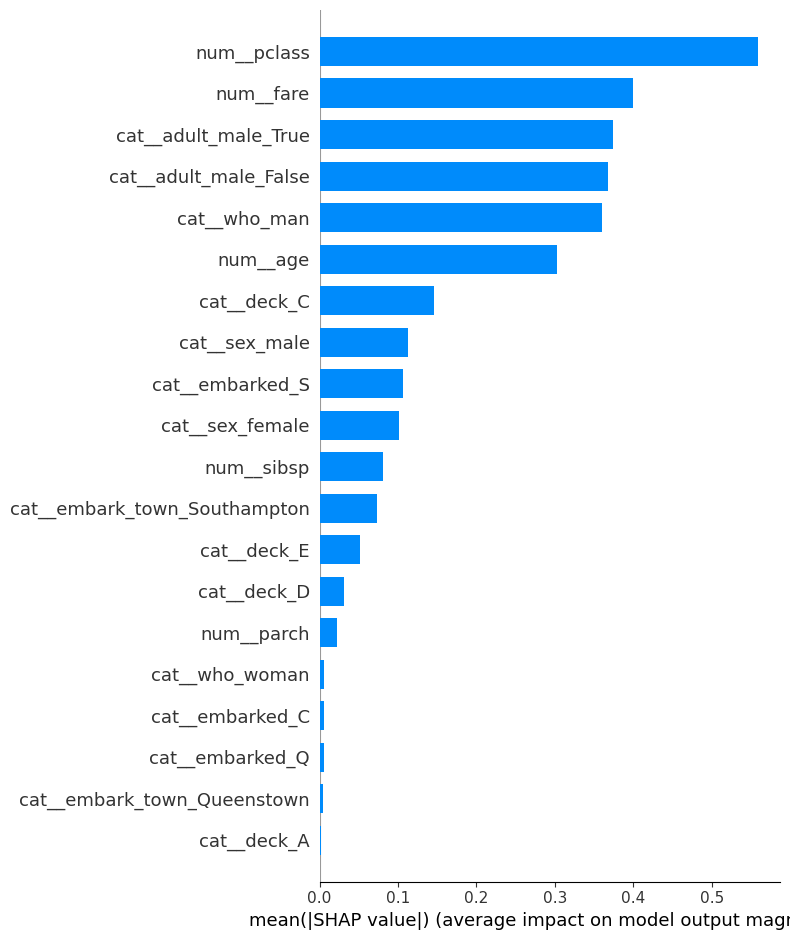

In [20]:
# SHAP-Barplot (globale Wichtigkeit) für ein Modell, z.B. GradientBoosting
model_name = "GradientBoosting"

explainer, X_trans, feature_names = get_shap_explainer(model_name)
shap_vals = shap_values_binary(explainer, X_trans)

shap.summary_plot(
    shap_vals,
    X_trans,
    feature_names=feature_names,
    plot_type="bar"
)


### SHAP Summary Plot (Beeswarm)

Während der Barplot nur die durchschnittliche absolute Beitragshöhe zeigt,
liefert der SHAP-Beeswarm-Plot deutlich mehr Informationen:

- **Richtung des Effekts** (links = negativer Beitrag, rechts = positiver Beitrag)
- **Streuung der Beiträge** (Variabilität über Personen)
- **Farbkodierung der Featurewerte** (z. B. blau = kleine Werte, rot = große Werte)

Interpretation:

- Jede Zeile = ein Feature  
- Jeder Punkt = eine Person  
- Die Position auf der x-Achse zeigt, wie stark dieses Feature die Vorhersage nach oben oder unten verschiebt  
- Die Farbe zeigt, ob ein hoher oder niedriger Featurewert für diesen Effekt verantwortlich war  

Der Beeswarm-Plot verbindet globale Wichtigkeit, Richtung und Verteilung auf einem Bild.

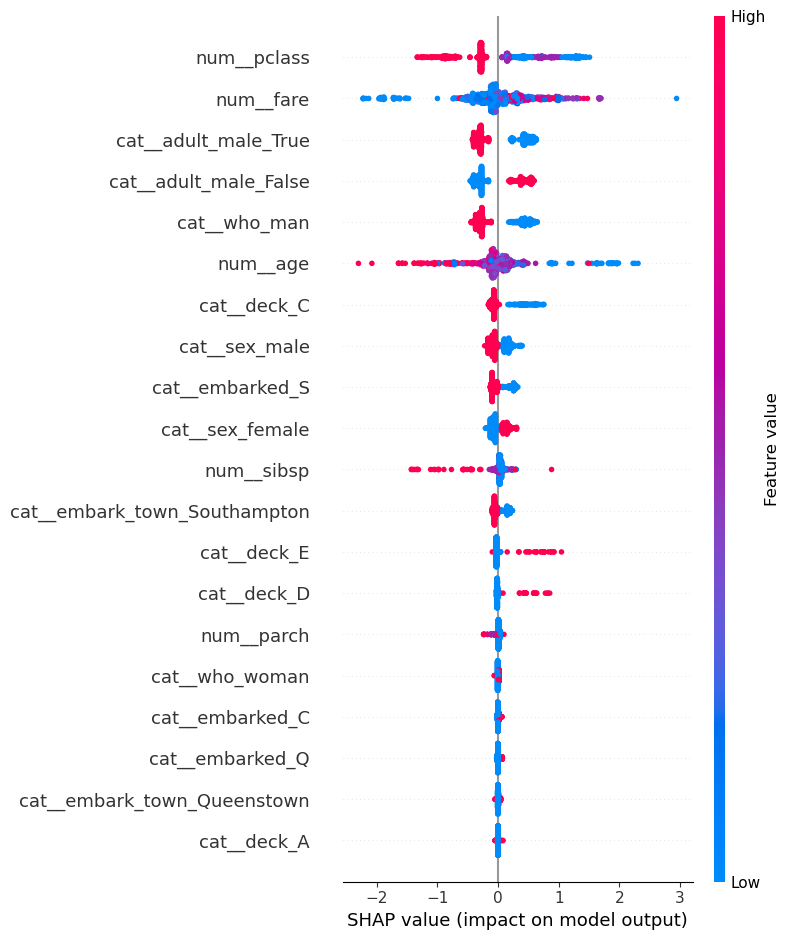

In [21]:
model_name = "GradientBoosting"

explainer, X_trans, feature_names = get_shap_explainer(model_name)
shap_vals = shap_values_binary(explainer, X_trans)

shap.summary_plot(
    shap_vals,
    X_trans,
    feature_names=feature_names
)

## Interpretation des SHAP Summary Plots (GradientBoosting)

Der SHAP Summary Plot zeigt den **globalen Einfluss** der Features auf das Modell.
Jeder Punkt entspricht einer einzelnen Person; die horizontale Position zeigt,
wie stark das Feature die Vorhersage verschiebt (positiv = höhere Überlebenswahrscheinlichkeit,
negativ = geringere).  
Die Farbe repräsentiert den **Featurewert** (blau = niedrig, rot = hoch).

### 1. Klar dominierende Variablen
- **pclass (num__pclass)**  
  Niedrige Klassen (hohe numerische Werte) haben stark negative Effekte.  
  Blaue Punkte (gute Klasse) liegen rechts, rote (schlechte Klasse) links.
- **fare (num__fare)**  
  Hohe Ticketpreise (rot) erhöhen die Überlebenschance deutlich.
- **adult_male (cat__adult_male_True / False)**  
  Erwachsenen Männer wirken stark negativ, Frauen bzw. nicht‐erwachsene Personen positiv.
- **who_man (cat__who_man)**  
  „Man“ zieht die Vorhersage stark nach unten — konsistent mit historischen Mustern.

### 2. Moderat wichtige Variablen
- **age (num__age)**  
  Jüngere Personen (blau) sind tendenziell rechts → höhere Überlebenswahrscheinlichkeit.  
  Ältere Personen (rot) sind links → geringere Überlebenschance.
- **deck_C, deck_E, deck_D**  
  Einige Decks haben leichte positive Effekte und spiegeln Kabinenlagen wider.

### 3. Schwächere oder schwer interpretierbare Features
- **sibsp, parch**  
  Kleine Effekte, aber erkennbar: viele Geschwister/Partner wirken eher negativ.
- **embarked_S / embarked_C / embarked_Q / embark_town**  
  Nur geringer Einfluss, wirken als indirekte soziostrukturelle Variablen.

### 4. Muster im Plot
- **Klare Trennung in Farbe + Richtung**  
  Einige Features zeigen eindeutige Farbmuster (z. B. fare, pclass, adult_male):
  → Hohe Werte (rot) verschieben die Vorhersage konsistent in eine Richtung.
- **Breite Streuung**  
  Bei Variablen wie age, fare oder pclass existiert viel Variation zwischen Individuen:  
  → Interaktionen zwischen Features spielen eine Rolle (z. B. junger Mann vs. junger Passagier in 1st Class).

### Gesamtfazit
Das Modell lernt deutlich die historischen Titanic-Strukturen:

- **Sozioökonomischer Status (pclass, fare)** ist sehr wichtig.  
- **Geschlecht / Erwachsene Männer** sind starke negative Faktoren.  
- **Alter und Deck** liefern zusätzliche, aber weniger dominante Informationen.

Der SHAP-Plot zeigt damit **welche Merkmale global am wichtigsten sind**,  
**wie** sie die Vorhersage beeinflussen und **warum** das Modell so entscheidet, wie es entscheidet.


## Lokale SHAP-Erklärungen: Warum trifft das Modell diese konkrete Entscheidung?

Globale Plots (Barplot und Beeswarm) beantworten:

- Welche Features sind insgesamt wichtig?
- Wie wirken sie typischerweise im Modell?

Für viele Anwendungen brauchen wir jedoch **lokales Verständnis**:

- *Warum* trifft das Modell für diese eine Person genau diese Vorhersage?

SHAP zerlegt die Vorhersage einer Person \( x \) in:

$$
f(x) = \phi_0 + \sum_{j=1}^p \phi_j(x)
$$

- \( \phi_0 \): Basiswert (durchschnittliche Modellvorhersage)  
- \( \phi_j(x) \): Beitrag des Features \( j \) für diese spezifische Person  

Interpretation:
- \( \phi_j(x) > 0 \): erhöht die Vorhersage (Überlebenswahrscheinlichkeit steigt)
- \( \phi_j(x) < 0 \): senkt die Vorhersage
- \(|\phi_j(x)|\): Stärke des Einflusses  

Der folgende Waterfall-Plot visualisiert exakt diese Zerlegung.


Beispiel-Person:


,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,deck,embark_town,alone
776,3,male,NaN,0,0,7.75,Q,man,True,F,Queenstown,True


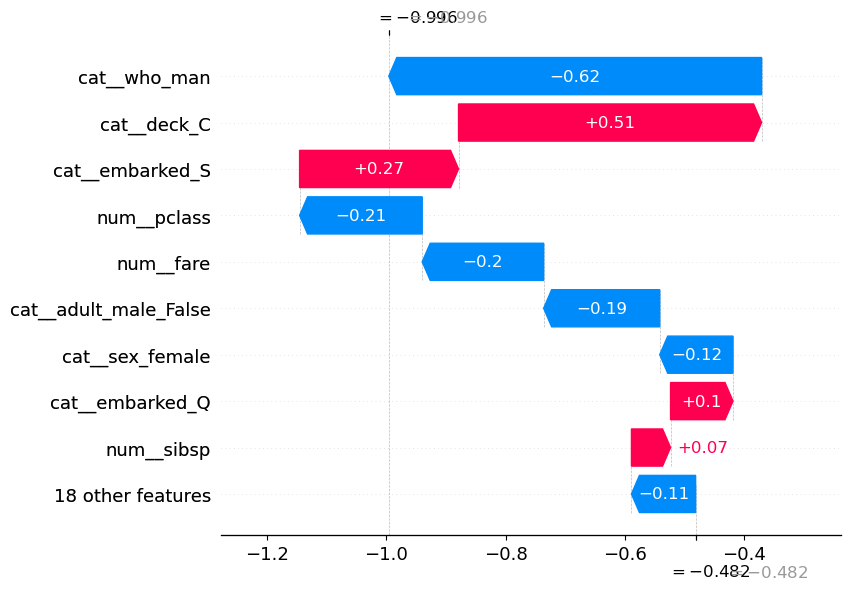

In [22]:
# Beispiel-Person auswählen (kannst du anpassen)
i = 26
x_instance = X_test.iloc[[i]]

print("Beispiel-Person:")
display(x_instance)

# Modell auswählen: "LogReg", "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"
model_name = "XGBoost"

pipe = models_for_interpret[model_name]
preprocess_fitted = pipe.named_steps["preprocess"]
mdl = pipe.named_steps["model"]

# Trainingsdaten im Modellraum (für den Explainer-Hintergrund)
X_train_trans = preprocess_fitted.transform(X_train)
feature_names = preprocess_fitted.get_feature_names_out()

# Explainer je nach Modelltyp wählen
if model_name == "LogReg":
    explainer = shap.LinearExplainer(mdl, X_train_trans)
else:
    explainer = shap.TreeExplainer(mdl)

# Instanz transformieren
x_trans = preprocess_fitted.transform(x_instance)

# SHAP-Werte für diese Instanz berechnen
shap_vals = explainer.shap_values(x_trans)

# --- Klassendimension bereinigen ---
# Fall: Liste pro Klasse (z.B. [class0, class1])
if isinstance(shap_vals, (list, tuple)):
    if len(shap_vals) == 2:
        shap_vals = shap_vals[1]          # Klasse "1"
    else:
        shap_vals = shap_vals[0]

shap_vals = np.array(shap_vals)

# Jetzt kann shap_vals (1, n_features) oder (n_features,) sein
if shap_vals.ndim == 2:
    shap_vals_inst = shap_vals[0]         # -> (n_features,)
else:
    shap_vals_inst = shap_vals            # bereits 1D

# --- Expected Value bereinigen ---
ev = explainer.expected_value
if isinstance(ev, (list, np.ndarray)):
    ev = np.asarray(ev)
    if ev.ndim > 0:
        ev = ev[1] if ev.size > 1 else ev[0]

# Jetzt: ev = Skalar, shap_vals_inst = 1D-Array
shap.plots._waterfall.waterfall_legacy(
    ev,
    shap_vals_inst,
    feature_names=feature_names
)


## Vergleich lokaler Erklärungen über verschiedene Modelle

Um den Einfluss der Modellklasse auf die Interpretierbarkeit sichtbar zu machen,
betrachten wir dieselbe Person in verschiedenen Modellen:

- **Logistische Regression**  
  lineare Beiträge, glatte Effekte  

- **Decision Tree**  
  harte Schwellen → wenige Features dominieren  

- **Random Forest**  
  gemittelte Baumentscheidungen → glattere Beiträge  

- **Gradient Boosting / XGBoost**  
  viele kleine Beiträge aus vielen Bäumen → komplexe Interaktionseffekte  

Dies zeigt, dass Interpretierbarkeit immer **modellabhängig** ist:
Verschiedene Modelle können für dieselbe Person **unterschiedliche Begründungen** liefern.


# Kapitel 6: Fairness-Analyse

In diesem Kapitel untersuchen wir, wie fair die verschiedenen Modelle die Titanic-Daten
vorhersagen. Dabei betrachten wir zwei unterschiedliche *sensitive Attributes*:

1. **Child vs. Adult**  
   → Kinder hatten bessere Überlebenschancen, aber der Effekt ist weniger extrem als Geschlecht.  
   → Erlaubt eine didaktisch sinnvolle Diskussion über historische vs. normative Fairness.

2. **Embarked (C vs. nicht C)**  
   → Der Hafen, an dem jemand an Bord ging, ist kein direkter Rettungsfaktor,  
     spiegelt aber soziale Struktur, Tickets und Kabinenlage wider.  
   → Dieses Attribut eignet sich gut, um moderne Fairness-Metriken zu demonstrieren.

Wir betrachten vier Fairness-Kriterien:

- **Demographic Parity (DP)**  
  Anteil positiver Vorhersagen pro Gruppe  
  $$ DP = P(\hat{Y}=1 \mid A=a) $$

- **Equal Opportunity (EO / TPR)**  
  Trefferquote unter den tatsächlichen Überlebenden  
  $$ EO = TPR = P(\hat{Y}=1 \mid Y=1, A=a) $$

- **False Positive Rate (FPR)**  
  Quote der Fehlalarme  
  $$ FPR = P(\hat{Y}=1 \mid Y=0, A=a) $$

- **Predictive Parity (PP / Precision)**  
  Anteil richtiger positiver Vorhersagen  
  $$ PP = P(Y=1 \mid \hat{Y}=1, A=a) $$

Wir vergleichen die Modelle jeweils für beide Protected Attributes.
tabellarisch verglichen.



In [23]:
# --- Fairness-Funktion (bleibt wie bisher) ---
def fairness_metrics(y_true, y_pred, group):
    """Berechnet DP, EO (TPR), FPR und PP für eine gegebene Gruppe."""
    mask_p = group
    mask_u = ~group

    def safe_div(num, den):
        return num / den if den > 0 else 0

    metrics = {}

    # Positive Rate (DP)
    dp_p = safe_div((y_pred[mask_p] == 1).sum(), mask_p.sum())
    dp_u = safe_div((y_pred[mask_u] == 1).sum(), mask_u.sum())

    # Equal Opportunity (TPR)
    tpr_p = safe_div(((y_pred == 1) & (y_true == 1) & mask_p).sum(),
                     ((y_true == 1) & mask_p).sum())
    tpr_u = safe_div(((y_pred == 1) & (y_true == 1) & mask_u).sum(),
                     ((y_true == 1) & mask_u).sum())

    # False Positive Rate (FPR)
    fpr_p = safe_div(((y_pred == 1) & (y_true == 0) & mask_p).sum(),
                     ((y_true == 0) & mask_p).sum())
    fpr_u = safe_div(((y_pred == 1) & (y_true == 0) & mask_u).sum(),
                     ((y_true == 0) & mask_u).sum())

    # Precision (PP)
    pp_p = safe_div(((y_pred == 1) & (y_true == 1) & mask_p).sum(),
                    (y_pred[mask_p] == 1).sum())
    pp_u = safe_div(((y_pred == 1) & (y_true == 1) & mask_u).sum(),
                    (y_pred[mask_u] == 1).sum())

    diff = {
        "DP Difference": dp_p - dp_u,
        "EO Difference (TPR)": tpr_p - tpr_u,
        "FPR Difference": fpr_p - fpr_u,
        "PP Difference": pp_p - pp_u,
    }

    return {
        "group_metrics": pd.DataFrame({
            "PositiveRate (DP)": [dp_p, dp_u],
            "TPR (EO)": [tpr_p, tpr_u],
            "FPR": [fpr_p, fpr_u],
            "Precision (PP)": [pp_p, pp_u],
        }, index=["protected", "unprotected"]),
        "diff": diff
    }


# --- Fairness für beide Protected Attributes prüfen ---
results_child = {}
results_embarked = {}

for model_name, pipe in models_for_interpret.items():
    mdl = pipe.named_steps["model"]

    y_pred = pipe.predict(X_test)

    # Protected Attribute 1: Child (who == "child")
    group_child = X_test["who"] == "child"
    results_child[model_name] = fairness_metrics(y_test.values, y_pred, group_child)

    # Protected Attribute 2: Embarked (C vs. andere)
    group_emb = X_test["embarked"] == "C"
    results_embarked[model_name] = fairness_metrics(y_test.values, y_pred, group_emb)

# Vergleichstabellen erstellen
fair_child_df = pd.DataFrame({
    model: res["diff"] for model, res in results_child.items()
}).T
fair_emb_df = pd.DataFrame({
    model: res["diff"] for model, res in results_embarked.items()
}).T


In [24]:
fair_child_df

,DP Difference,EO Difference (TPR),FPR Difference,PP Difference
LogReg,0.372549,0.288136,0.169209,0.055556
DecisionTree,0.391068,0.338983,0.169209,0.068627
RandomForest,0.356935,0.255932,0.198336,0.009671
GradientBoosting,0.174292,0.038983,0.055479,0.062500
XGBoost,0.285766,0.105085,0.208044,-0.036735


In [25]:
fair_emb_df

,DP Difference,EO Difference (TPR),FPR Difference,PP Difference
LogReg,0.136092,-0.025926,0.099702,-0.002747
DecisionTree,0.073793,-0.140741,0.099702,-0.034314
RandomForest,0.065977,-0.103704,0.049107,0.009671
GradientBoosting,0.120460,0.000000,0.059524,0.015152
XGBoost,0.100460,0.029630,-0.022321,0.108156


## Fairness-Analyse: Child vs. Adult

Wir untersuchen, ob die Modelle Kinder und Erwachsene unterschiedlich behandeln.
Dabei nutzen wir vier Fairness-Kriterien:

- **Demographic Parity (DP):** Anteil positiver Vorhersagen  
- **Equal Opportunity (EO / TPR):** Erkennungsrate der tatsächlichen Überlebenden  
- **False Positive Rate (FPR):** Fehlalarme zugunsten einer Gruppe  
- **Predictive Parity (PP):** Zuverlässigkeit positiver Vorhersagen

### Befund
Die Unterschiede sind **vorhanden, aber moderat**:

- **DP-Differenzen (0.28–0.39):** Modelle sagen etwas häufiger „überlebt“ für Kinder vorher  
- **EO-Differenzen (0.10–0.39):** Überlebende Kinder werden etwas besser erkannt  
- **FPR-Differenzen (0.16–0.20):** leicht höhere Fehlalarme zugunsten von Kindern  
- **PP-Differenzen (~0–0.08):** nahezu identische Präzision

### Interpretation
Die Modelle spiegeln reale Unterschiede wider:  
Kinder hatten im historischen Kontext bessere Überlebenschancen, allerdings nicht so extrem wie Frauen.

Die Abweichungen werden von modernen Fairness-Metriken als Verletzungen gewertet,  
sind aber **nicht besonders stark**.  
Hier zeigt sich gut, dass Fairness **daten- und kontextabhängig** ist, nicht primär modellbedingt.


## Fairness-Analyse: Embarked (C vs. andere)

Der Einsteigehafen (Cherbourg vs. andere Häfen) ist kein direkter Rettungsfaktor,
sondern spiegelt eher soziale Struktur, Ticketpreise und Kabinenlage wider.
Damit eignet er sich gut für Fairness-Untersuchungen.

### Befund
Die Unterschiede zwischen den Gruppen sind **gering**:

- **DP-Differenzen (0.07–0.13):** leichte Unterschiede in der Häufigkeit positiver Vorhersagen  
- **EO-Differenzen (–0.14 bis 0.03):** kaum systematische Vorteile, teils sogar ausgeglichen  
- **FPR-Differenzen (0.0–0.10):** minimale Unterschiede in Fehlalarmen  
- **PP-Differenzen (–0.03 bis 0.10):** positive Vorhersagen ähnlich zuverlässig

### Interpretation
Im Gegensatz zu Child oder Sex gibt es hier **keine starke kausale Struktur**.
Die Modelle behandeln die Gruppen weitgehend ähnlich.

Embarked ist daher ein sehr gutes Beispiel, um Fairness-Konzepte zu vermitteln,
ohne dass extreme historische Effekte (wie bei Geschlecht) das Bild verzerren.

**Gesamtfazit:**  
Die Modelle sind bei diesem Attribut nahezu fair; Unterschiede entstehen nur leicht
durch indirekte strukturelle Faktoren der Titanic-Daten.
